# Workshop 1
This workshop was realized by:
- David Plazas Escudero
- Andres Felipe Tamayo
- Juan Sebastián Cárdenas Rodríguez.

## Packages and Global Behavior

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy as sc

from PIL import Image
from matplotlib import cm, colors
from sklearn.covariance import ledoit_wolf, oas

eps = 1e-5
%matplotlib inline
matplotlib.rcParams["figure.facecolor"] = "white"
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

dir_fig = lambda x: "figs/" + x

## Exercise 4
In this cell, the multivariate normal data is generated. The number of points generated are given by the variable `n` and their parameters are given by `mu` and `sigma`.

In [48]:
n = 10000
mu = np.array([0, 0])
sigma = np.array([[1, 0], [0, 1]])

# Data Generation
data = np.random.multivariate_normal(mu, sigma, size=n)

In this cell, different distances are defined. All the functions recieve a data set `data` and a center for which the distance will be calculated `mu`.

The different methods defined are
- `distance_r2` that is used in the slide 26, it was the only applicable to bivariate data.
- `distance_eucl` this is the usual euclidean distance.

Furthermore, a proxy `distance_p` was created. This proxy recieves a value `p` and returns the p-distance function, with 0 being the mahalanobis distance.

In [3]:
def distance_r2(data, mu):
    distance = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        x = data[i, :]
        aux = np.power(x, 2) + np.power(mu, 2)
        if (np.abs(aux[0] - aux[1]) < eps):
            distance[i] = np.sqrt(np.power(x[0] - mu[0], 2) + np.power(x[1] - mu[1], 2))
        else:
            distance[i] = np.sqrt(aux[0]) + np.sqrt(aux[1])
    return distance

##########################
def distance_eucl(data, mu):
    diff = data - mu
    return np.sqrt(np.power(diff, 2).sum(-1))

##########################
def distance_p(p):
    def aux_distance(data, mu):
        diff = np.abs(data - mu)
        return np.power(np.power(diff, p).sum(-1), 1/p)
    def mahalanobis(data, mu, icov):
        diff = data - mu
        return np.sqrt((diff.dot(icov) * diff).sum(-1))
    if p == 0:
        return mahalanobis
    return aux_distance

In the next cell the outliers where removed, painted in red. This where done by calculating the distance of each point to their mean `mu` and removes the ones that are higher than the 90 percentile.

The distance function used is the `distance_r2`.

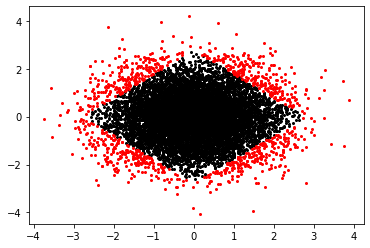

In [49]:
# Distances and percentile
distances = distance_r2(data, mu)
perc_90 = np.percentile(distances, 90)

# Data separation
data_small = data[distances <= perc_90, :]
data_big = data[distances > perc_90, :]

# Plotting
plt.scatter(data_small[:, 0], data_small[:, 1], color='k', s=4)
plt.scatter(data_big[:, 0], data_big[:, 1], color='r', s=4)
plt.show()

## Exercise 5
In the next cell the functions defined for the algorithm k-means are displayed.

- `find_membership` is a function that finds the group that each data point belongs to, by some fixed centers given in the variable `prototypes`. This is useful to precisely update the centroids in the algorithm and further plot the clusters.
- `plot_clusters` is a function that plots the clusters for some given centroids and membership matrix.
- `k_means` is the main function, as it executes the k-means algorithms. To generalize even further this method recieves the distance function required to run, therefore allowing for different testing.

In [9]:
def find_membership(data, dist, prototypes, args):
    k = prototypes.shape[0]
    u = np.zeros((k, data.shape[0]))
    distances = np.zeros((k, data.shape[0]))
    for j in range(k):
        distances[j, :] = dist(data, prototypes[j, :], *args)
    indexes_min = np.argmin(distances, axis=0)
    for j in range(u.shape[1]):
        u[:, j] = 0
        u[indexes_min[j], j] = 1

    return u

##########################
def plot_clusters(proto, memberships, data):
    color1 = plt.get_cmap('winter')
    color_norm = colors.Normalize(vmin=0, vmax=proto.shape[0] - 1)
    scalar_map = cm.ScalarMappable(norm=color_norm, cmap=color1)
    for j in range(proto.shape[0]):
        data_group = data[memberships[j, :] == 1, :]
        color = scalar_map.to_rgba(j)
        plt.scatter(data_group[:, 0], data_group[:, 1], color=color, s=4)
    plt.scatter(proto[:, 0], proto[:, 1], color='k', s=8)
    plt.show()

##########################
def k_means(data, k, dist, n_iter, args):
    # Random selection of k prototypes
    indexes = np.array(range(data.shape[0]))
    selection = np.random.choice(indexes, size=k, replace=False)
    prototypes = data[selection, :]

    for i in range(n_iter):
        # Find membership
        u = find_membership(data, dist, prototypes, args)

        # Update prototypes
        prototypes = np.divide(u.dot(data), np.reshape(u.sum(-1), (u.shape[0], 1)))

    return prototypes, find_membership(data, dist, prototypes, args)


In the next cell the previous multivariate normal distribution is partition by the k-means algorithm to show how it works.

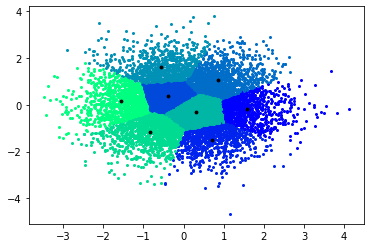

In [10]:
# Number of clusters
k = 8
proto, memberships = k_means(data, k, distance_eucl, 100, [])

# Plotting
plot_clusters(proto, memberships, data)

In the next cell, three different multivariate normal distribution samples are generated and mixed. This will be useful to test how efficient the k-means algorithm is.

In [13]:
# Means
mu1, mu2, mu3 = np.array([0, 0]), np.array([1, 1]), np.array([10, 10])

# Covariances
cov1 = np.array([[3, 0], [0, 1]])
cov2 = np.array([[2, 0], [0, 3]])
cov3 = np.array([[1.1, 0], [0, 2.2]])

# Data
data1 = np.random.multivariate_normal(mu1, cov1, size=3000)
data2 = np.random.multivariate_normal(mu2, cov2, size=3000)
data3 = np.random.multivariate_normal(mu3, cov3, size=3000)

# Mixture
mixture = np.concatenate((data1, data2, data3))

### K-Means
In the next cell the k-means algorithm is executed for the mahalanobis norm and the $p$-norm for $p = 1, 2$.

In [14]:
# Simulation for three different metrics
ps = [0, 1, 2]
protos, memberships = [], []
for p in ps:
    if p == 0:
        args = [np.linalg.inv(cov1)]
    else:
        args = []
    proto, memb = k_means(mixture, 3, distance_p(p), 100, args)
    protos.append(proto)
    memberships.append(memb)

#### Mahalanobis

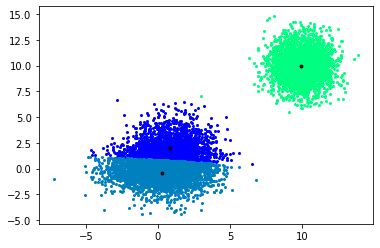

In [15]:
plot_clusters(protos[0], memberships[0], mixture)

For this cell, instead of using the covariance of the first data set the covariance was estimated by the usual methods and the mahalanobis distance was calculated using it.

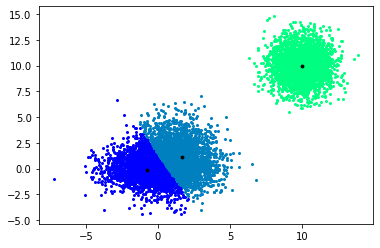

In [20]:
cov = np.cov(data.T)
args = [np.linalg.inv(cov)]
proto, memb = k_means(mixture, 3, distance_p(0), 100, args)

plot_clusters(proto, memb, mixture)

#### 1-norm

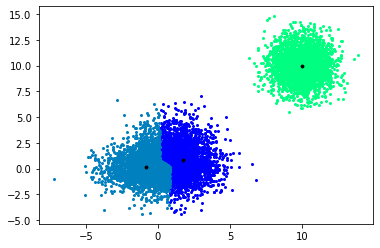

In [16]:
plot_clusters(protos[1], memberships[1], mixture)

#### 2-norm

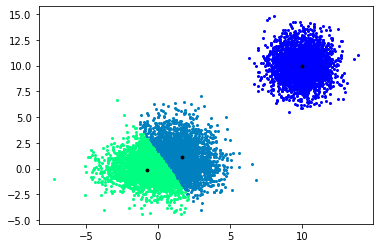

In [17]:
plot_clusters(protos[2], memberships[2], mixture)

## Exercise 7
For this exercise, it is important to notice that a minimum kurtosis function is not currently implemented in python therefore it could not be tested. Furthermore, a translation to this language was not done due to lack of time. Therefore, the robust matrix will be tested with `kendall`.

In first place, the data of the portafolio is read.

In [24]:
# Read assets data
file = open("portfolio100.txt").readlines()
data = []
for line in file:
    row = []
    acum = ""
    for char in line:
        if char != " ":
            acum += char
        if char == " " and len(acum) != 0:
            row.append(float(acum))
            acum = ""
    if acum != "":
        row.append(float(acum))
    data.append(row)

data_port = np.array(data, dtype=np.float)

For the removal of outliers, a similar process to the first points is realized. This is done in order to compare precisely how the distances where affected by the given covariance.

In [60]:
def remove_outliers(dataset, cov):
    mean = np.mean(dataset, axis = 0)
    distances = distance_p(0)(dataset, mean, np.linalg.inv(cov))
    perc_90 = np.percentile(distances, 90)

    # Data separation
    data_small = dataset[distances <= perc_90, :]
    data_big = dataset[distances > perc_90, :]
    
    return data_small, data_big

Therefore, three different covariance matrices where defined using the proposed methods in the exercise. The result for each of the outlier removals using the different covariances can be seen in the following graphs.

In [61]:
def corr_to_cov(data, correlation):
        stds = data.std(axis=0, ddof=1)
        cov = np.zeros(correlation.shape)
        for i in range(correlation.shape[0]):
            for j in range(correlation.shape[1]):
                cov[i, j] = correlation[i, j] * stds[i] * stds[j]
        return cov

# Calculate each covariance
cov1 = np.cov(data_port.T)
cov2, _ = ledoit_wolf(data_port)
cov3 = corr_to_cov(data_port, pd.DataFrame(data_port).corr(method="kendall").to_numpy())

# Calculate each data
data_small1, data_big1 = remove_outliers(data_port, cov1)
data_small2, data_big2 = remove_outliers(data_port, cov2)
data_small3, data_big3 = remove_outliers(data_port, cov3)

#### Usual Covariance Estimation

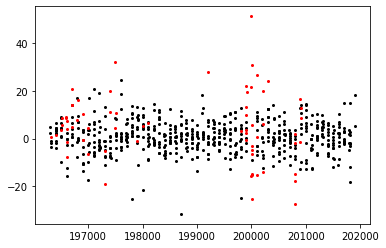

In [62]:
plt.scatter(data_small1[:, 0], data_small1[:, 1], color='k', s=4)
plt.scatter(data_big1[:, 0], data_big1[:, 1], color='r', s=4)
plt.show()

#### Ledoit Wolf Shrinkages

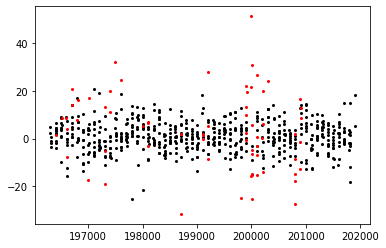

In [63]:
plt.scatter(data_small2[:, 0], data_small2[:, 1], color='k', s=4)
plt.scatter(data_big2[:, 0], data_big2[:, 1], color='r', s=4)
plt.show()

#### Kendall Estimation

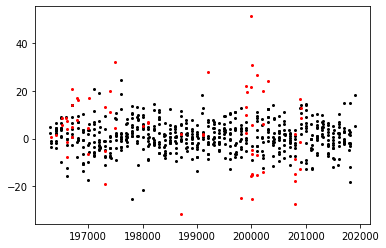

In [64]:
plt.scatter(data_small3[:, 0], data_small3[:, 1], color='k', s=4)
plt.scatter(data_big3[:, 0], data_big3[:, 1], color='r', s=4)
plt.show()

## Exercise 8
In the following cell, the different binary distances can be seen and can be obtained by the function `binary_distances`. It is important to notice that
- `method = 0` is the Pearson distance.
- `method = 1` is the Jaccard distance
- `method = 2` is the Dice distance.

In [77]:
def binary_distances(matrix, means, method=0):
    dists = np.zeros(matrix.shape[1])
    for j in range(matrix.shape[1]):
        a = 0
        b = 0
        c = 0
        d = 0
        for i in range(matrix.shape[0]):
            if matrix[i, j] == means[j]:
                cond = int(matrix[i, j] == 1)
                a += cond
                d += 1 - cond
            else:
                cond = int(matrix[i, j] == 1)
                b += cond
                c += 1 - cond
        if method == 0:
            dists[j] = (a*d - b*c) / (np.sqrt((a+c) * (b+d) * (a+b) * (c+d)))
        elif method == 1:
            dists[j] = a / (a + b + c)
        elif method == 2:
            dists[j] = 2*a / (2*a + b + c)
    return dists

In [78]:
# Mean of the data set
means_port = np.mean(data_port, axis=1)
aux = np.zeros(data_port.shape[0])
aux[means_port > 0] = 1

# Auxiliar binary matrix
mat_aux = np.zeros(data_port.shape)
mat_aux[data_port > 0] = 1

# Distance to mean
distances = binary_distances(mat_aux, aux, method=1)

Therefore, the more similar and dissimilar actives are

In [81]:
indices_sorted = distances.argsort()

# The lowest distance
print("More similar to mean")
print(indices_sorted[:10])

# The biggest distances
print("\nMore dissimilar to the mean")
print(indices_sorted[-10:])

More similar to mean
[91 10 20 30 50 90 80 70 60 40]

More dissimilar to the mean
[47 44 43  4 67 28 54 45 46  0]


## Exercise 10
Base photo for the exercise.

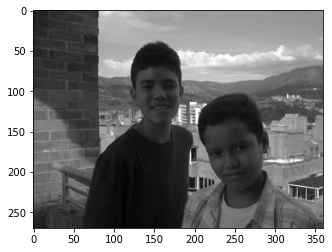

In [67]:
image = np.array(Image.open("photo.jpg").convert("L"))
plt.imshow(image, cmap='gray')
plt.show()

Function that constructs the succession.

In [65]:
def succession(image, n):
    aux = np.zeros(image.shape)
    aux[:, :int(image.shape[1] / 2)] = image[:, :int(image.shape[1] / 2)] + 1000 / n
    aux[:, int(image.shape[1] / 2):] = image[:, int(image.shape[1] / 2):] + 500 * n ** 2 / (n**3 - n + 1)
    return aux


Showing the elements of the succession. The last element is the 1000-th element of the succession, as it is clearly seen that it is pretty similar to the real image.

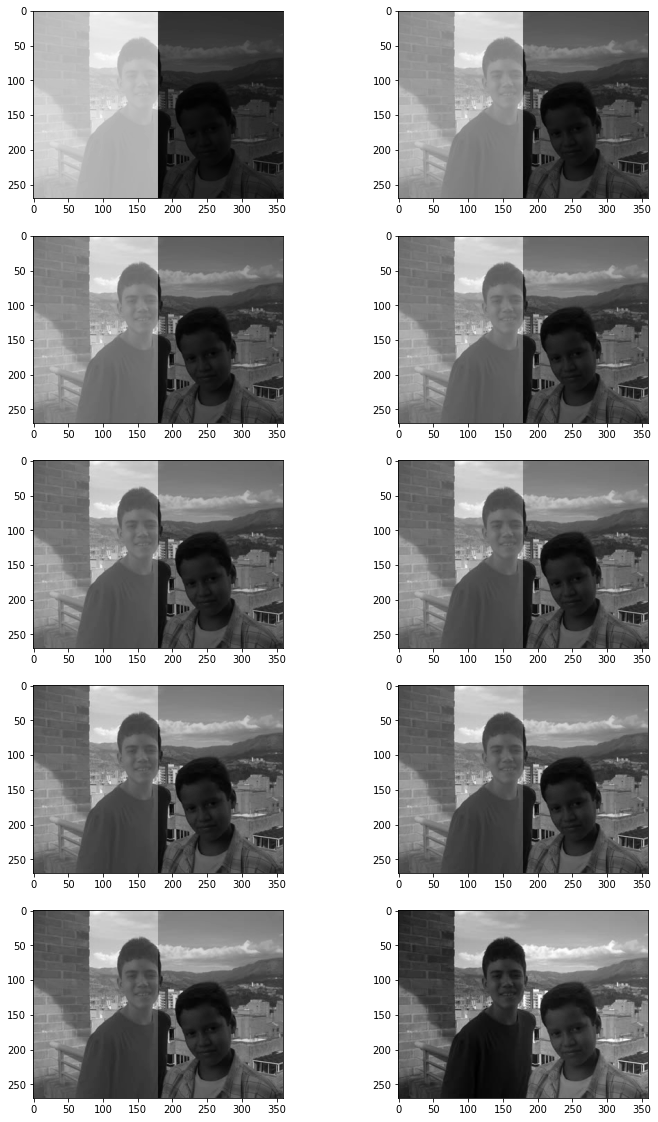

In [68]:
ns = list(range(1, 10)) + [1000]
_, axs = plt.subplots(int(len(ns) / 2), 2, figsize=(12, 20))
i = 0
j = 0
for n in ns:
    elem = succession(image, n)
    axs[i, j].imshow(elem, cmap='gray')
    if j != 0 and (j-1) % axs.shape[1] == 0:
        i += 1
        j = 0
    else:
        j += 1

plt.show()

In this cell the image to a certain distance of the original image is given. For execution times and as normally matrix norms are quite large, the bound for this $n$ was considered to be large as well.

n such that the distance is less than 100: 2701

---Image---


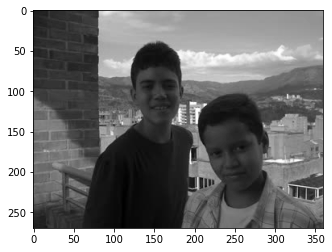

In [75]:
n = 1
while True:
    image_n = succession(image, n)
    if np.linalg.norm(image - image_n, ord = -np.inf) < 100:
        break
    n += 1

print("n such that the distance is less than 100:", n)
print("\n---Image---")
plt.imshow(image_n, cmap='gray')
plt.show()

## Exercise 11
For this exercise, a set of additional photos where chosen given in adjoint files.

In the next cell some functions to find an indicator of distance and to read all the images can be found.

In [82]:
def distance(subject1, subject2, norm):
    distance = 0
    first = True
    for image in subject1:
        for image0 in subject2:
            aux = np.linalg.norm(image - image0, ord=norm)
            if first:
                distance = aux
                first = False
            elif aux < distance:
                distance = aux

    return distance

def all_remotes(pics, norm):
    distances = {}
    for key in pics:
        sum = 0
        count = 0
        for key0 in pics:
            if key == key0:
                continue
            sum += distance(pics[key], pics[key0], norm)
            count += 1
        distances[key] = sum / count
    return distances

def all_distances(pics, norm):
    distances = {}
    for key in pics:
        dists = {}
        for key0 in pics:
            if key == key0:
                continue
            dists[key0] = distance(pics[key], pics[key0], norm)
        distances[key] = list(dists.items())
    return distances


### Image Reading

In [98]:
pics = {}
directory = "group-pictures"
name_regex = re.compile(r"[A-Za-z]+")
size = (200, 180)
for filename in os.listdir(directory):
    name = name_regex.match(filename).group(0)
    image = np.array(Image.open(os.path.join(directory, filename)).resize(size).convert("L"))
    if name in pics:
        pics[name].append(image)
    else:
        pics[name] = [image]


### Norm-1

The distance to all the group is 25940.82608695652

The mean of the group is given by


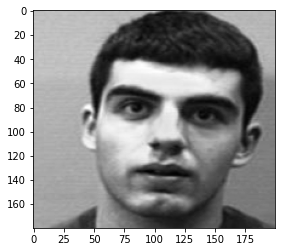

In [102]:
remotes = list(all_remotes(pics, 1).items())
order = sorted(remotes, key=lambda x: x[1])

# Output
print("The distance to all the group is", order[0][1])
print("\nThe mean of the group is given by")
plt.imshow(pics[order[0][0]][0], cmap = 'gray')
plt.show()

### Frobenius Norm

The distance to all the group is 23456.962744517215

The mean of the group is given by


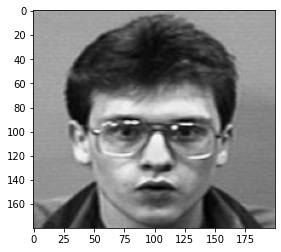

In [103]:
remotes = list(all_remotes(pics, 'fro').items())
order = sorted(remotes, key=lambda x: x[1])

# Output
print("The distance to all the group is", order[0][1])
print("\nThe mean of the group is given by")
plt.imshow(pics[order[0][0]][0], cmap = 'gray')
plt.show()

### Infinite Norm

The distance to all the group is 28331.956521739132

The mean of the group is given by


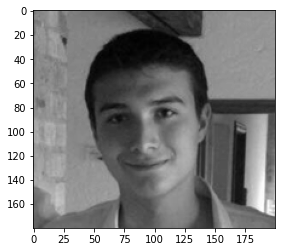

In [104]:
remotes = list(all_remotes(pics, np.inf).items())
order = sorted(remotes, key=lambda x: x[1])

# Output
print("The distance to all the group is", order[0][1])
print("\nThe mean of the group is given by")
plt.imshow(pics[order[0][0]][0], cmap = 'gray')
plt.show()

## Exercise 12
The function `image_radius` calculates the radius for a given person using the distances by the Frobenius norm.

In [106]:
def images_radius(n, id1, distances):
    dists = sorted(distances[id1], key=lambda x: x[1])
    pics_near = dists[:n]
    return pics_near, pics_near[-1][-1]


In [108]:
ditsts0 = all_distances(pics, 'fro')
center = "sbains"

# Find radius
for key in ditsts0:
    ditsts0[key] = sorted(ditsts0[key], key=lambda x: x[1])
elements, radius = images_radius(5, center, ditsts0)

# Output
print("For", center, "the elements at distance", radius, "are")
i = 1
for elem in elements:
    print(i, ".", elem[0])
    i += 1


For sbains the elements at distance 26407.405192483413 are
1 . DP
2 . CL
3 . NA
4 . JS
5 . A


## Exercise 13
A shrinkage was applied in order to better the condition number.

In [109]:
cov, _ = ledoit_wolf(data_port)

# Output
print("The condition number for the normal covariance is", np.linalg.cond(np.cov(data_port.T))) 
print("The condition number for the shrinkage is", np.linalg.cond(cov))
print("ratio =", np.linalg.cond(np.cov(data_port.T)) / np.linalg.cond(cov))


The condition number for the normal covariance is 1807336.046739744
The condition number for the shrinkage is 79256.07334520064
ratio = 22.80375459515731


The OAS method was applied to improve the condition number.

In [112]:
cov1, _ = oas(data_port)

# Output
print("The condition number for the normal covariance is", np.linalg.cond(np.cov(data_port.T))) 
print("The condition number for the OAS is", np.linalg.cond(cov1))
print("ratio =", np.linalg.cond(np.cov(data_port.T)) / np.linalg.cond(cov1))

The condition number for the normal covariance is 1807336.046739744
The condition number for the OAS is 32641.882385421366
ratio = 55.36862198691528


## Exercise 14
Condition number for the hilbert matrix.

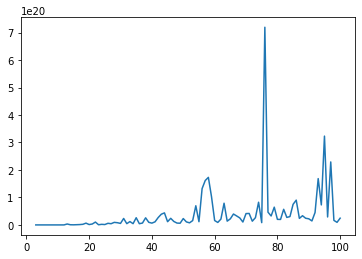

In [113]:
ns = list(range(3, 101))
hilb = list(map(lambda n: sc.linalg.hilbert(n), ns))

conds = list(map(lambda h: np.linalg.cond(h), hilb))
plt.plot(ns, conds)
plt.show()

Condition number for the hilbert matrix by a shrinkage.

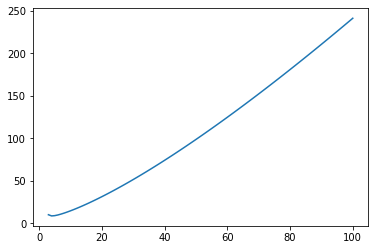

In [144]:
conds2 = list(map(lambda h: np.linalg.cond(ledoit_wolf(h)[0]), hilb))
plt.plot(ns, conds2)
plt.show()


Determinant for the hilbert matrix.

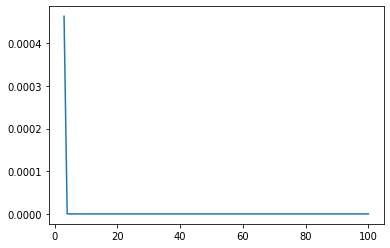

In [145]:
dets = list(map(lambda h: np.linalg.det(h), hilb))
plt.plot(ns, dets)
plt.show()


Determinant for the hilbert matrix shrinked.

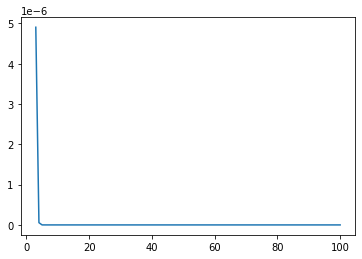

In [146]:
dets = list(map(lambda h: np.linalg.det(ledoit_wolf(h)[0]), hilb))
plt.plot(ns, dets)
plt.show()
